Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](../figures/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb)

## Setup environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/spleen')

In [4]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.9 MB/s eta 0:00:00


In [ ]:
# !python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

## Setup imports

In [5]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print_config()

MONAI version: 1.5.dev2442
Numpy version: 1.26.4
Pytorch version: 2.5.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d850fe3e5160f867a27d3f9e45f7ca1e4c7e53e5
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.20.0+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.44.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

In [6]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.5.dev2442
Numpy version: 1.26.4
Pytorch version: 2.5.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d850fe3e5160f867a27d3f9e45f7ca1e4c7e53e5
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.20.0+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.44.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

In [7]:
from monai.transforms import CropForegroundd

# 使用 keys 和 source_key 初始化 CropForegroundd
crop_transform = CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=False)

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
# Replace these paths with the actual paths to your subfolders
subfolder1_path = './imagesTr'
subfolder2_path = './labelsTr'

# List the contents of the first subfolder
# contents_subfolder1 = os.listdir(subfolder1_path)
contents_subfolder1 = sorted(os.listdir(subfolder1_path))
contents_subfolder1 = [file for file in contents_subfolder1 if file != '.DS_Store' ]
print("Contents of Subfolder 1:", contents_subfolder1)

# List the contents of the second subfolder
# contents_subfolder2 = os.listdir(subfolder2_path)
contents_subfolder2 = sorted(os.listdir(subfolder2_path))
contents_subfolder2 = [file for file in contents_subfolder2 if file != '.DS_Store' ]

print("Contents of Subfolder 2:", contents_subfolder2)

Contents of Subfolder 1: ['spleen_10.nii.gz', 'spleen_12.nii.gz', 'spleen_13.nii.gz', 'spleen_14.nii.gz', 'spleen_16.nii.gz', 'spleen_17.nii.gz', 'spleen_18.nii.gz', 'spleen_19.nii.gz', 'spleen_2.nii.gz', 'spleen_20.nii.gz', 'spleen_21.nii.gz', 'spleen_22.nii.gz', 'spleen_24.nii.gz', 'spleen_25.nii.gz', 'spleen_26.nii.gz', 'spleen_27.nii.gz', 'spleen_28.nii.gz', 'spleen_29.nii.gz', 'spleen_3.nii.gz', 'spleen_31.nii.gz', 'spleen_32.nii.gz', 'spleen_33.nii.gz', 'spleen_38.nii.gz', 'spleen_40.nii.gz', 'spleen_41.nii.gz', 'spleen_44.nii.gz', 'spleen_45.nii.gz', 'spleen_46.nii.gz', 'spleen_47.nii.gz', 'spleen_49.nii.gz', 'spleen_6.nii.gz', 'spleen_8.nii.gz', 'spleen_9.nii.gz']
Contents of Subfolder 2: ['spleen_10.nii.gz', 'spleen_12.nii.gz', 'spleen_13.nii.gz', 'spleen_14.nii.gz', 'spleen_16.nii.gz', 'spleen_17.nii.gz', 'spleen_18.nii.gz', 'spleen_19.nii.gz', 'spleen_2.nii.gz', 'spleen_20.nii.gz', 'spleen_21.nii.gz', 'spleen_22.nii.gz', 'spleen_24.nii.gz', 'spleen_25.nii.gz', 'spleen_26.nii

In [ ]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
# if directory is not None:
#     os.makedirs(directory, exist_ok=True)
# root_dir = tempfile.mkdtemp() if directory is None else directory
# print(root_dir)

## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [ ]:
# resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
# md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

# compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
# data_dir = os.path.join(root_dir, "Task09_Spleen")
# if not os.path.exists(data_dir):
#    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [ ]:
data_dir = '/content/drive/MyDrive/spleen'
root_dir = '/content/drive/MyDrive/spleen'

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

Image file: /content/drive/MyDrive/spleen/imagesTr/spleen_10.nii.gz
Label file: /content/drive/MyDrive/spleen/labelsTr/spleen_10.nii.gz


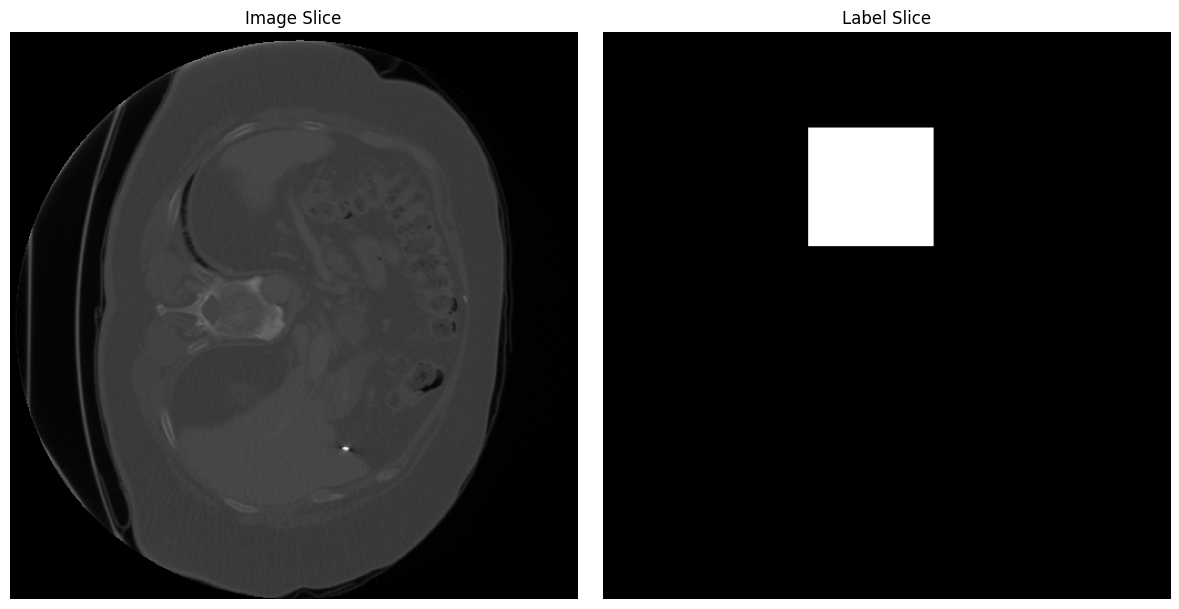

In [ ]:
# 选择一个样本索引
sample_index = 0

image_path = train_images[sample_index]
label_path = train_labels[sample_index]

image_nii = nib.load(image_path)
label_nii = nib.load(label_path)

image_data = image_nii.get_fdata()
label_data = label_nii.get_fdata()

slice_index = image_data.shape[2] // 2

print(f"Image file: {image_path}")
print(f"Label file: {label_path}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_data[:, :, slice_index], cmap='gray')
axes[0].set_title('Image Slice')
axes[0].axis('off')

axes[1].imshow(label_data[:, :, slice_index], cmap='gray')
axes[1].set_title('Label Slice')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def load_NIfTI_data(file_path):
    nifti_data = nib.load(file_path)
    # Get the data from the NIfTI object
    image_data = nifti_data.get_fdata()
    header = nifti_data.header
    return image_data


def plot_NIfTI_data(data):
    fig = plt.figure(figsize = (20,20))
    axes = fig.subplots(5,5)
    for i in range(5):
        for j in range(5):
            k = 5*i + j
            if k < data.shape[0]:
                slice_img = data[:,:,k]
                axes[i,j].imshow(slice_img)
                axes[i,j].set_title("z = {}".format(k+1))
            else:
                axes[i,j].axis('off')
    plt.show()


def adjust_nii_data(in_file, out_file):
    nifti_data = nib.load(in_file)
    image_data = nifti_data.get_fdata()
    data = image_data.copy()
    data = data[:,::-1,:].T
    data = np.transpose(data,(1,2,0))
    processed_nifti = nib.Nifti1Image(data, nifti_data.affine)
    nib.save(processed_nifti, out_file)


In [ ]:
# nii_files = []
# for root, dirs, files in os.walk("./allnii/"):
#     for file in files:
#         if file.endswith(".nii"):
#             nii_files.append(os.path.join(root, file))
# nii_files = sorted(nii_files)
# num_files = len(nii_files)
# assert num_files%2 ==0
# img_label_dict = {}
# for i in range(num_files // 2):
#     file1 = nii_files[2*i]
#     file2 = nii_files[2*i+1]
#     if file1.endswith("seg.nii"):
#         img_label_dict[file2] = file1
#     else:
#         img_label_dict[file1] = file2

# data_dict = img_label_dict


# paths = ['datalab', './datalab/imagesTr','./datalab/labelsTr', './datalab/tmp' ]
# for path in paths:
#   try:
#     os.mkdir(path)
#   except:
#     pass


## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` was changed in version 1.5 from `allow_smaller=True` to `allow_smaller=False`.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader

Batch 1: image shape: torch.Size([292, 276, 234]), label shape: torch.Size([292, 276, 234])


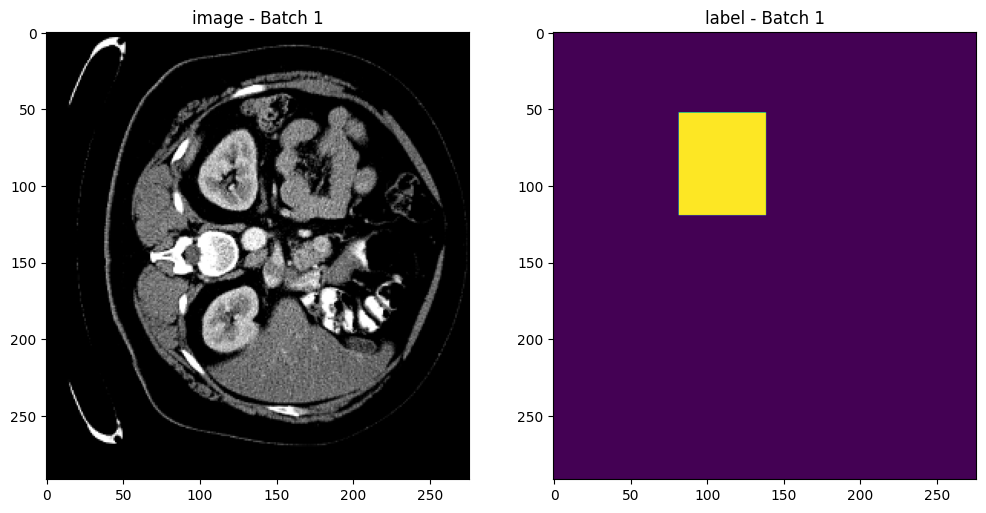

In [ ]:
n = 1
check_loader_iter = iter(check_loader)

# 获取第 n 个批次
for _ in range(n):
    check_data = next(check_loader_iter)

image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"Batch {n}: image shape: {image.shape}, label shape: {label.shape}")

# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"image - Batch {n}")
plt.imshow(image[:, :, 155], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"label - Batch {n}")
plt.imshow(label[:, :, 155])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [ ]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


## Create Model, Loss, Optimizer

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [ ]:
max_epochs = 200
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/200
1/12, train_loss: 0.5853
2/12, train_loss: 0.6099
3/12, train_loss: 0.6110
4/12, train_loss: 0.6399
5/12, train_loss: 0.5714
6/12, train_loss: 0.6360
7/12, train_loss: 0.5739
8/12, train_loss: 0.6424
9/12, train_loss: 0.5888
10/12, train_loss: 0.6128
11/12, train_loss: 0.5944
12/12, train_loss: 0.5581
epoch 1 average loss: 0.6020
----------
epoch 2/200
1/12, train_loss: 0.6436
2/12, train_loss: 0.6288
3/12, train_loss: 0.6138
4/12, train_loss: 0.6027
5/12, train_loss: 0.6118
6/12, train_loss: 0.5580
7/12, train_loss: 0.6015
8/12, train_loss: 0.5553
9/12, train_loss: 0.5774
10/12, train_loss: 0.5633
11/12, train_loss: 0.5882
12/12, train_loss: 0.6163
epoch 2 average loss: 0.5967
saved new best metric model
current epoch: 2 current mean dice: 0.0575
best mean dice: 0.0575 at epoch: 2
----------
epoch 3/200
1/12, train_loss: 0.5759
2/12, train_loss: 0.5613
3/12, train_loss: 0.5737
4/12, train_loss: 0.5702
5/12, train_loss: 0.6161
6/12, train_loss: 0.5527
7/12, train

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7812 at epoch: 148


## Plot the loss and metric

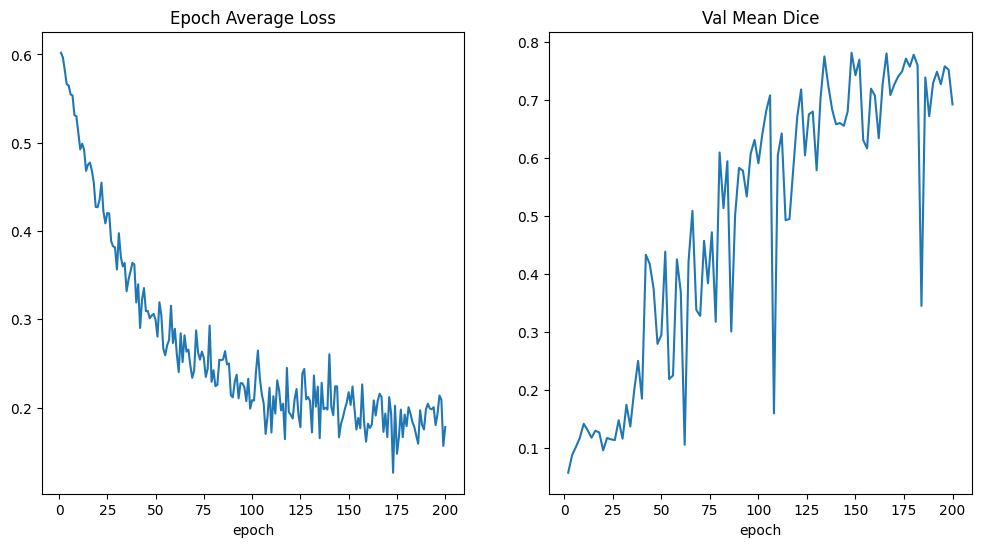

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

<ipython-input-106-16d514c0b86c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


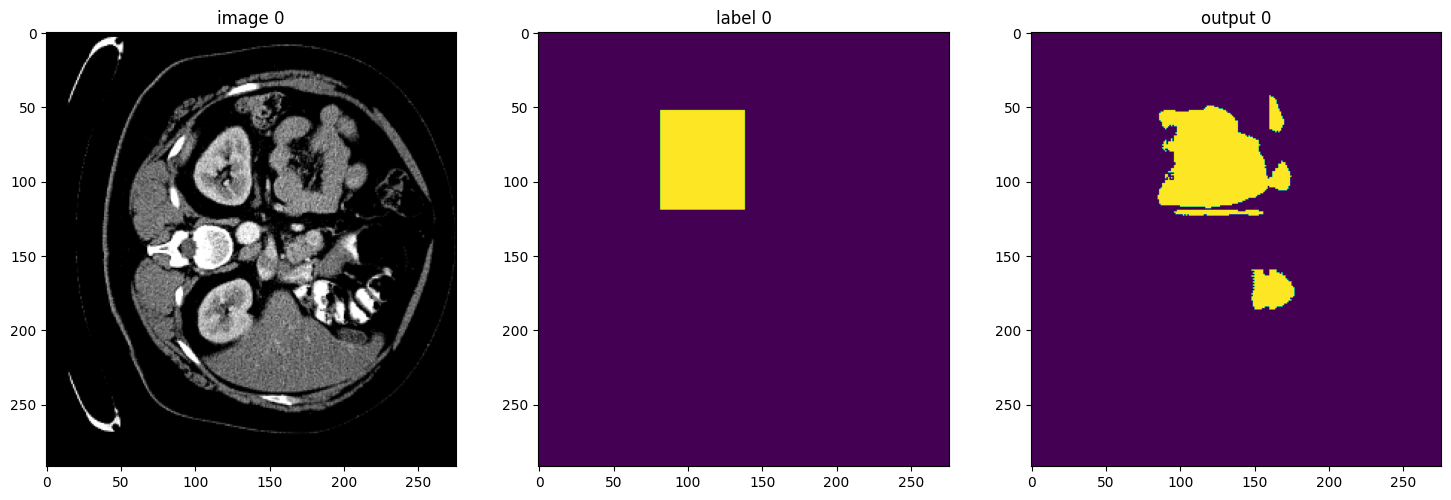

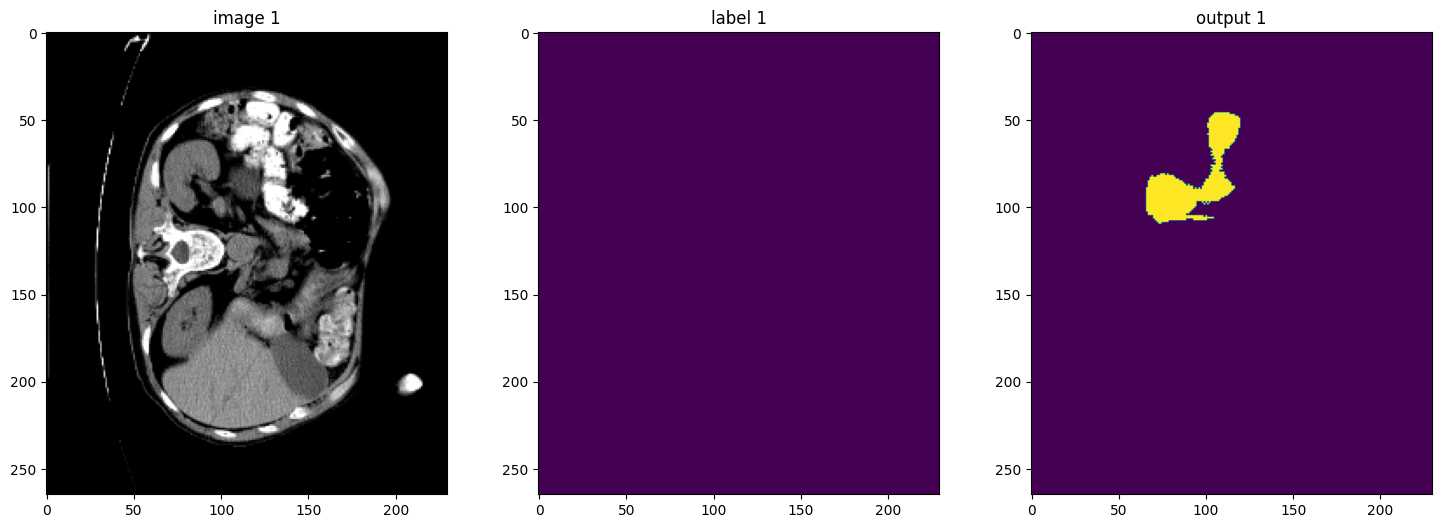

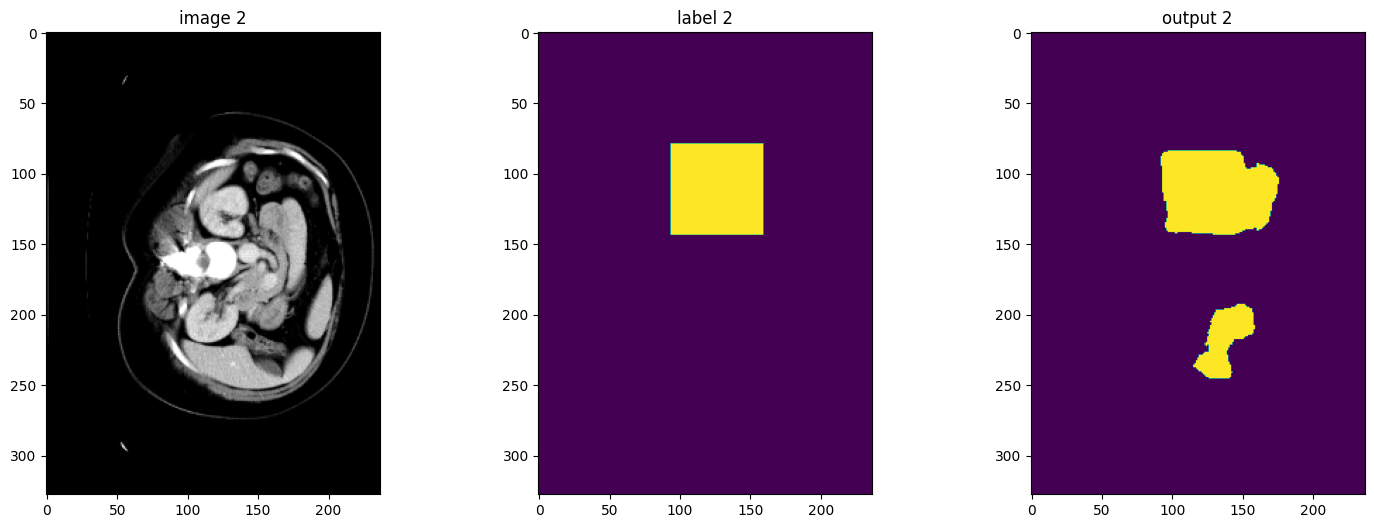

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 155], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 155])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 155])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

<ipython-input-108-805a1859a750>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))


Metric on original image spacing:  0.7823421955108643


## Inference on Test Set

In [ ]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

2024-10-21 09:11:41,573 INFO image_writer.py:197 - writing: out/spleen_52/spleen_52_seg.nii.gz


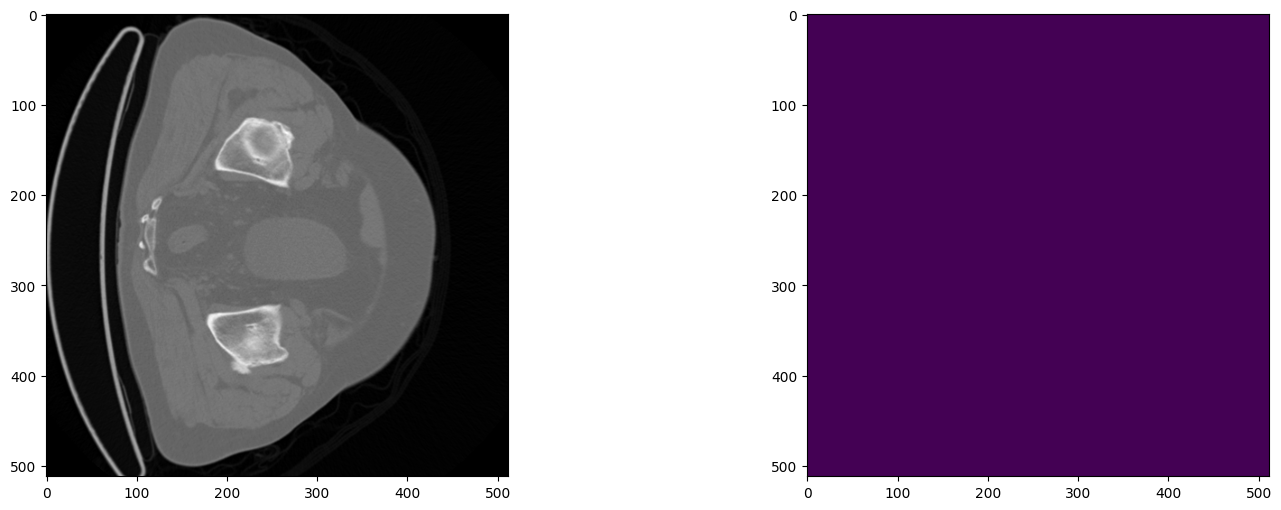

2024-10-21 09:11:45,986 INFO image_writer.py:197 - writing: out/spleen_53/spleen_53_seg.nii.gz


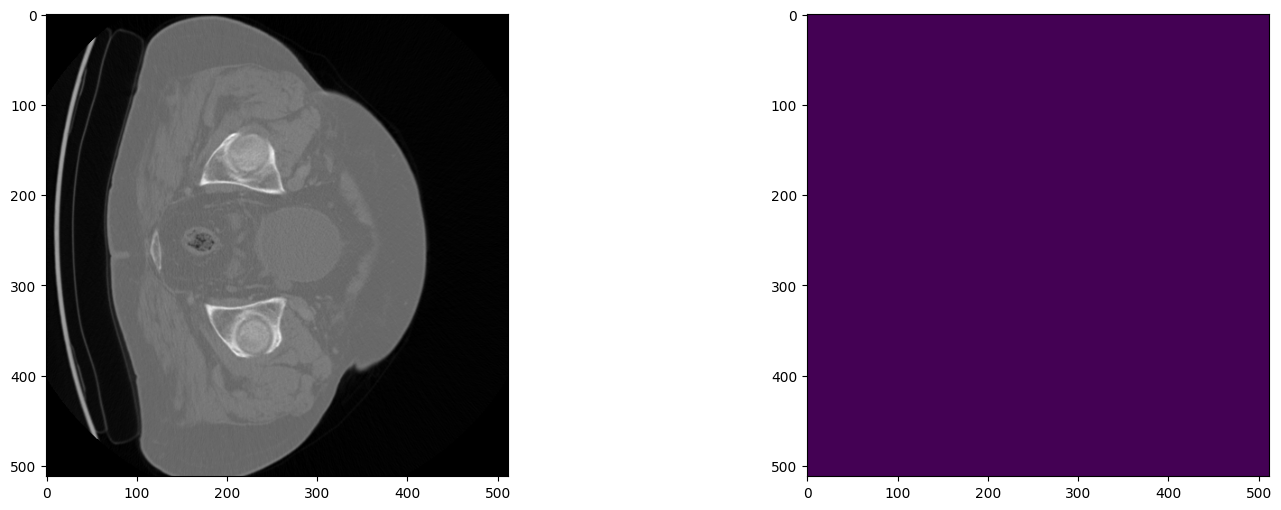

2024-10-21 09:11:50,976 INFO image_writer.py:197 - writing: out/spleen_56/spleen_56_seg.nii.gz


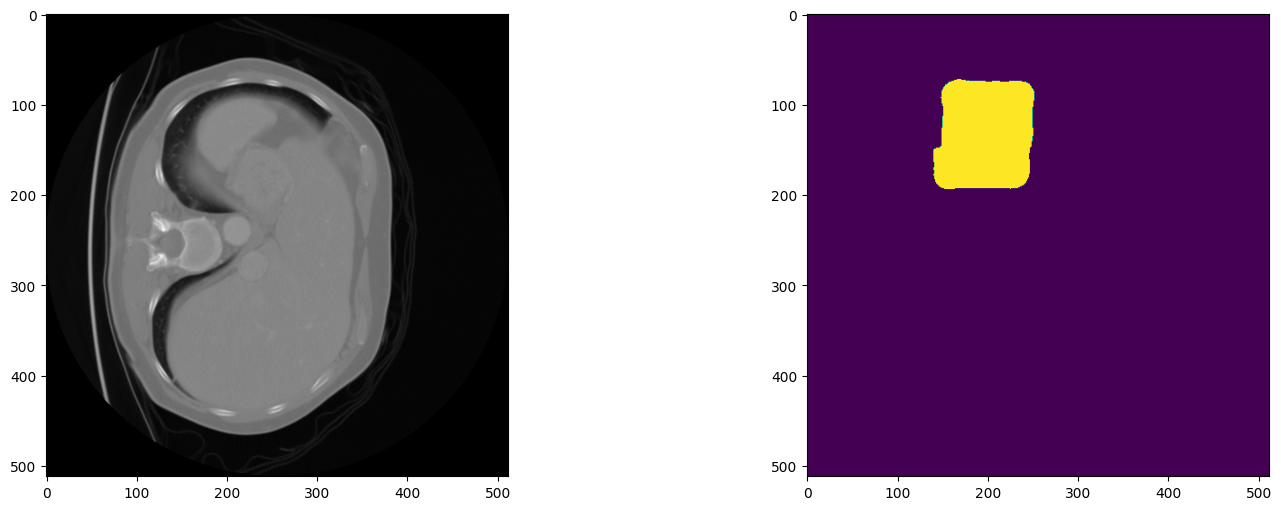

2024-10-21 09:11:52,418 INFO image_writer.py:197 - writing: out/spleen_59/spleen_59_seg.nii.gz


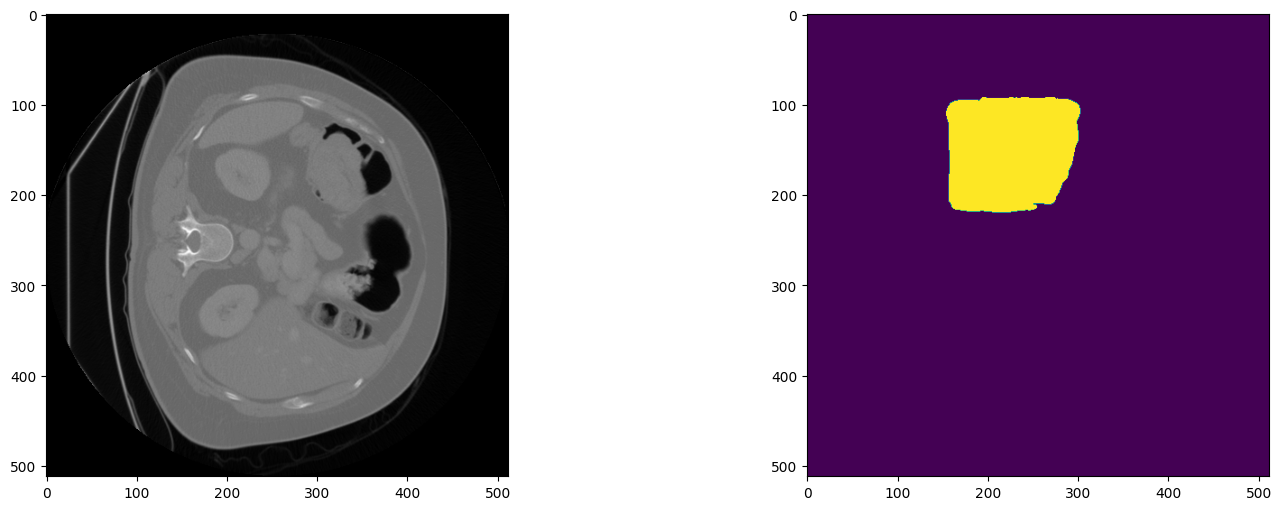

2024-10-21 09:11:54,427 INFO image_writer.py:197 - writing: out/spleen_60/spleen_60_seg.nii.gz


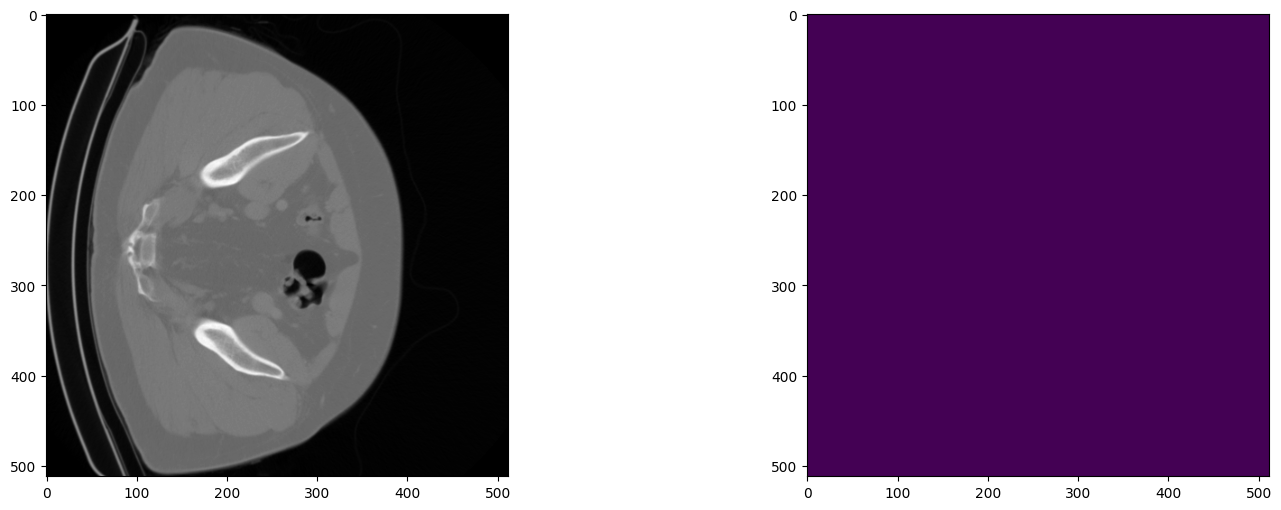

2024-10-21 09:11:57,726 INFO image_writer.py:197 - writing: out/spleen_61/spleen_61_seg.nii.gz


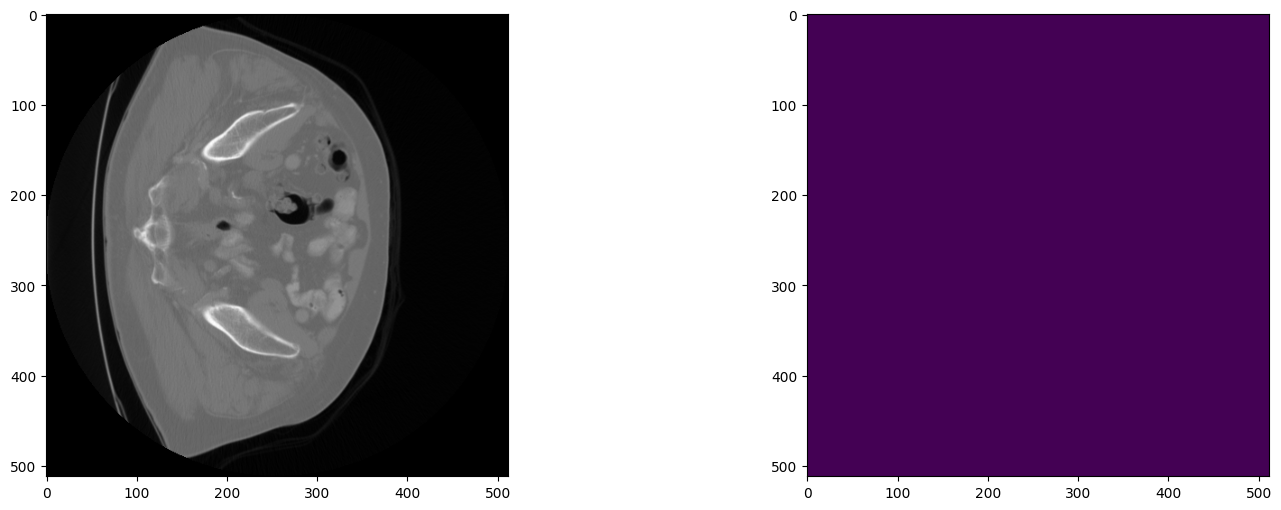

2024-10-21 09:12:01,042 INFO image_writer.py:197 - writing: out/spleen_62/spleen_62_seg.nii.gz


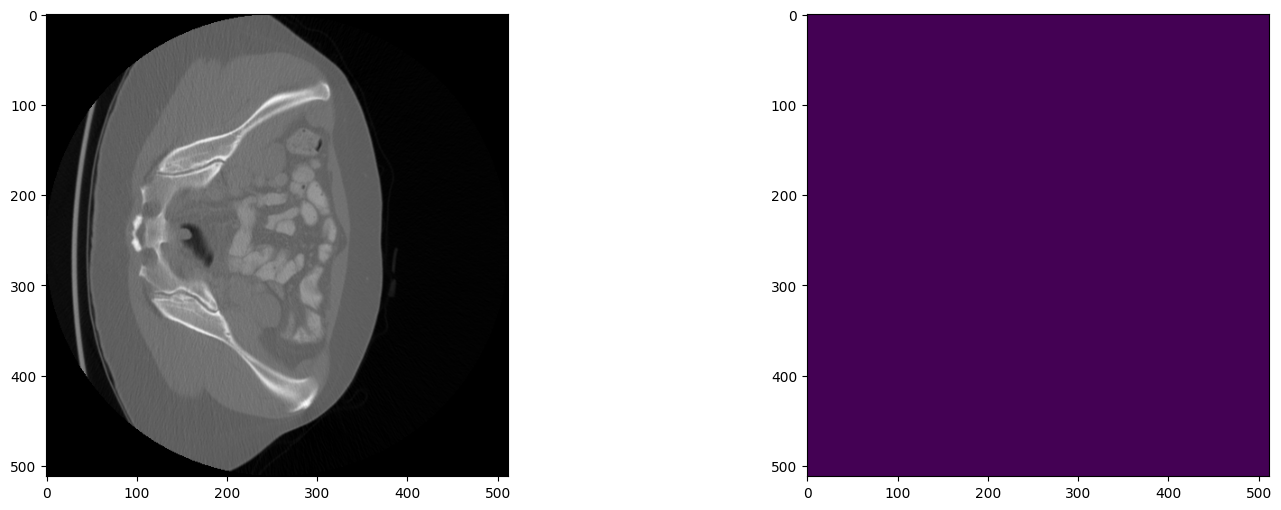

2024-10-21 09:12:03,950 INFO image_writer.py:197 - writing: out/spleen_63/spleen_63_seg.nii.gz


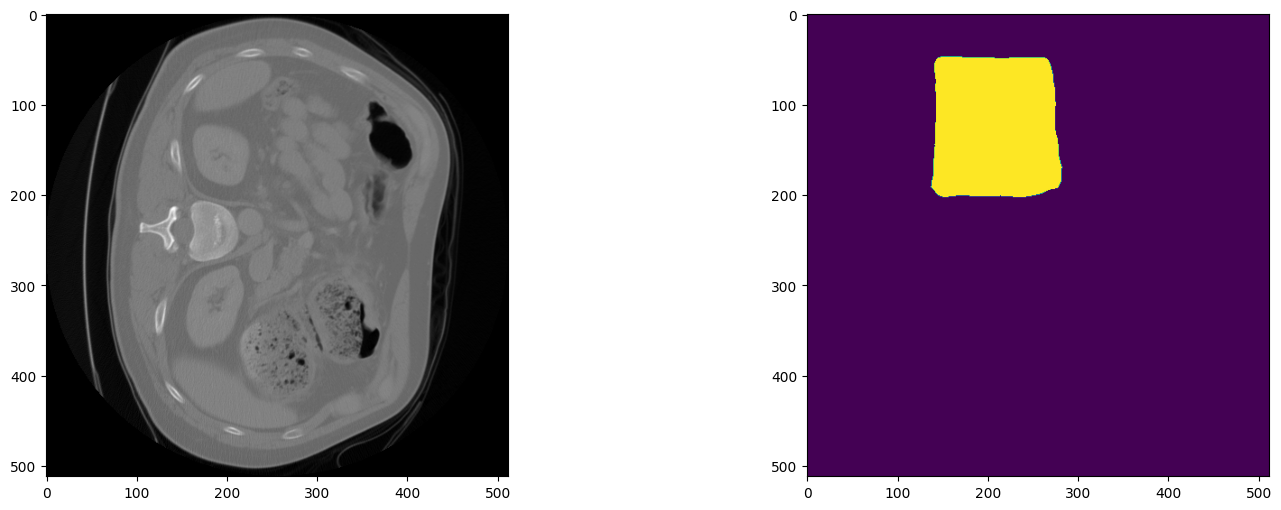

In [ ]:
import torch
import nibabel as nib
import matplotlib.pyplot as plt

# Function to load the image data
def loader(file_path):
    return nib.load(file_path)

# Securely loading the model state
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)

        # Load the image data and access the data array
        original_image = loader(test_output[0].meta["filename_or_obj"])
        original_image_data = original_image.get_fdata()  # Load full data into memory

        # Visualization
        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image_data[:, :, 25], cmap="gray")  # Corrected slicing
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 25])
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
# if directory is None:
#     shutil.rmtree(root_dir)

# grad cam